# BioSound Tutorial 4.  Supervised Classification with BioSound properties.
### This notebook illustrates how to perform LDA, QDA and RF on data that has been pre-processed by BioSound.

LDA : Linear Discriminant Analysis  
QDA : Quadratic Discriminant Analysis  
RF  : Random Forest  

At this stage, you have transformed all your sound files into BioSound objects and generated a pandas table where you have saved the parameters of interest as in tutorial 3.

## Step 1. Loading all the dependencies.  
### numpy, soundsig and pandas. 

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.discriminate import discriminatePlot
from scipy.stats import f, fisher_exact
from statsmodels.stats.proportion import binom_test

import matplotlib.pyplot as plt

# Make plots on this Notebook.
%matplotlib inline


## Step 2. Specifying the pandas table and reading it.

You will want to change the location for storing the pandas table to the one you specified in tutorial 3.

In [2]:
# The pandas data frame location (from tutorial 3):
tableStore = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocSelTable.h5'

# This is where you want to store eps of figures that will be generated.
figdir = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/'

# Let's read it:
vocSelTable = pd.read_hdf(tableStore)

# Subject performance to compare with classifier
subjectInfo = pd.read_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/success.csv', 
                       delimiter= ';', index_col = False, decimal = ',')

## Step 3. Supervised Classification with cross-validation.  

Here we are going to see how well baby id can be classified using lda, qda and rf.  The routine discriminatePlot fits these supervised classifiers after pre-processing.  The pre-processing involves removing groups that have insufficent data and performing a PCA on the features used by the classifier as a form of regularization (to prevent overfitting).  The PCA is performed when there is insufficent data in each group to get good estimates of the within group covariance matrix.  The performance of the classifiers using 10 fold cross-validation.  Alternatively, one can specify indexes that will be used uniquely in the testing set of the classifiers (testInd - see discriminatePlot() in soundsig/discriminate.  
In this particular example we are going to train with bath data and test on vaccination data.


In [3]:
#  Here we generate colors for each baby for plotting purposes:

# Color code for bird ID
babyColorStart = [(0/255.0, 230/255.0, 255/255.0),  
             (255/255.0, 0/255.0, 0/255.0), 
             (255/255.0, 180/255.0, 255/255.0),
             (140/255.0, 100/255.0, 185/255.0) ]


responseVar = 'Baby'

birdNames = np.unique(vocSelTable[responseVar])

# If you have a small number of birds you might want to choose specific colors
babyColor = {}
ib = 0
for birdId in birdNames:
    if ib < 4:
       babyColor[birdId] = babyColorStart[ib] 
    else:
       babyColor[birdId] = np.random.rand(3)
    ib += 1
    
cValBabyAll = []
for babyId in vocSelTable[responseVar]:
    cValBabyAll.append(babyColor[babyId])
    
cValBabyAll = np.asarray(cValBabyAll)

Variance explained is 100.00%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

DFA calculated with 286 points
LDA Weights:
DFA 0: sal 1.679; cvfund 1.618; F1 -0.005; minfund 0.004; fund 0.002; 
DFA 1: cvfund -4.662; sal -1.469; fund 0.014; minfund -0.004; F2 -0.001; 
DFA 2: cvfund -10.261; sal 2.017; minfund -0.016; F2 0.001; maxfund 0.000; 
Number of classes 22. Chance level 4.55 %
Fund + Formants LDA: 33.57 % (96/286 p=0.0000)
Fund + Formants QDA: 30.42 % (87/286 p=0.0000)
Fund + Formants RF: 39.86 % (114/286 p=0.0000)


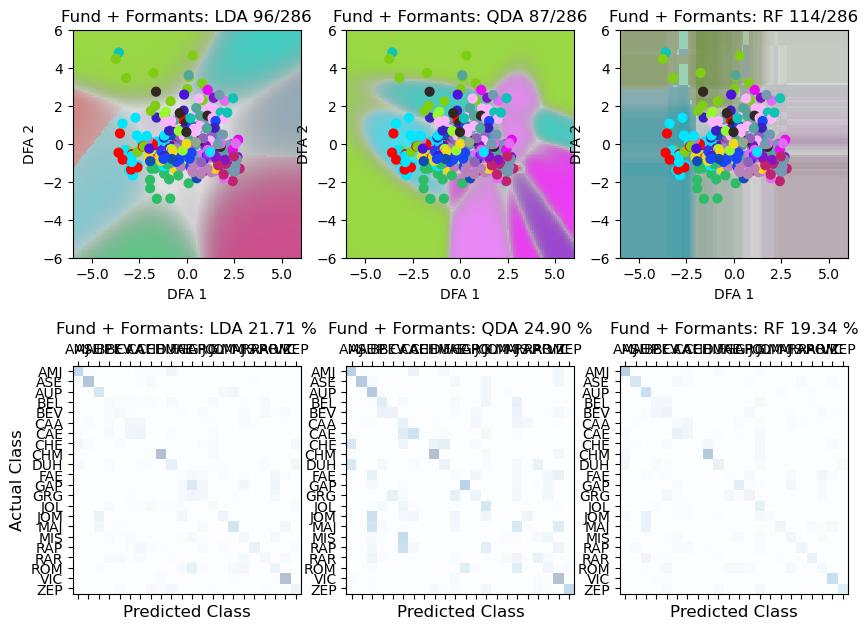

In [4]:
# Can we classify baby id using the average formants, pitch saliency, fundamental and the cv fund ?

# X is the data array of features.
# y is the variable name for the grouping variable 
XFeatureNames = np.hstack(('F1','F2','sal', 'fund','cvfund', 'maxfund', 'minfund'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable[responseVar])



# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Formants + Saliency + Fund Model 
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd], 
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Fund + Formants',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Mixed']),
     'Features': np.array(['Formants + Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }
     
resultsDataFrame = pd.DataFrame(data = d)

### Let's perform a second discrimination without using the formants.

Are formants helpful (beyond fundamental) to discriminate baby id?

Variance explained is 100.00%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

DFA calculated with 286 points
LDA Weights:
DFA 0: cvfund 5.392; sal 1.079; fund -0.014; minfund 0.005; maxfund -0.000; 
DFA 1: cvfund -9.797; sal 1.902; minfund -0.015; fund -0.001; maxfund 0.000; 
DFA 2: sal 11.080; cvfund 1.922; minfund -0.004; maxfund 0.003; fund 0.003; 
Number of classes 22. Chance level 4.55 %
Fund LDA: 18.88 % (54/286 p=0.0000)
Fund QDA: 21.68 % (62/286 p=0.0000)
Fund RF: 24.83 % (71/286 p=0.0000)


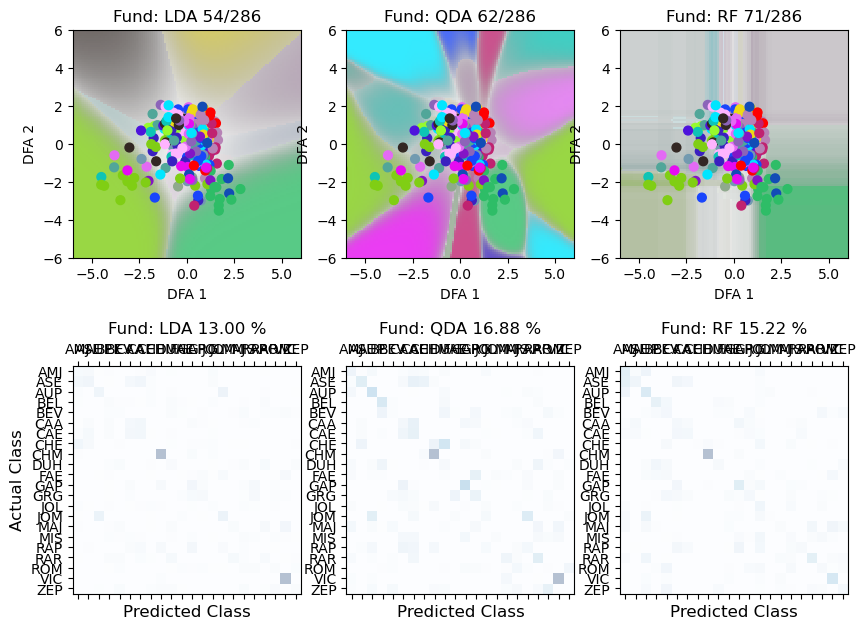

In [5]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('sal', 'fund',  'cvfund', 'minfund', 'maxfund'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Fund',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Mixed']),
     'Features': np.array(['Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

In this case, it can be seen that the Formants have quite a bit of information.



Variance explained is 100.00%
DFA calculated with 286 points
LDA Weights:
DFA 0: sal -0.454; F1 0.005; F2 -0.001; 
DFA 1: sal -1.369; F2 -0.003; F1 0.001; 
DFA 2: sal 10.889; F1 0.002; F2 -0.000; 
Number of classes 22. Chance level 4.55 %
Formants LDA: 21.33 % (61/286 p=0.0000)
Formants QDA: 20.63 % (59/286 p=0.0000)
Formants RF: 17.83 % (51/286 p=0.0000)


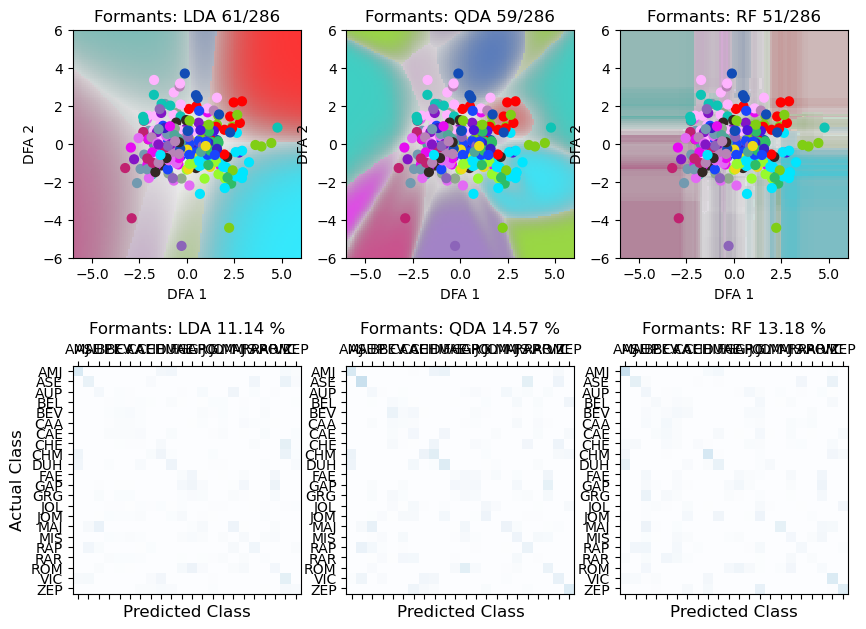

In [6]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('F1', 'F2', 'sal'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Formants Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Formants',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Mixed']),
     'Features': np.array(['Formants']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

Variance explained is 99.70%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

DFA calculated with 286 points
LDA Weights:
DFA 0: F1 -0.003; maxfund 0.002; meanS -0.001; F2 0.000; q1 0.000; 
DFA 1: F1 -0.004; F2 0.003; stdS -0.002; meanS -0.001; q3 0.001; 
DFA 2: F1 -0.003; stdS 0.002; maxfund -0.001; fund -0.001; q2 0.000; 
Number of classes 22. Chance level 4.55 %
22 PAFs LDA: 30.77 % (88/286 p=0.0000)
22 PAFs QDA: 30.77 % (88/286 p=0.0000)
22 PAFs RF: 37.41 % (107/286 p=0.0000)


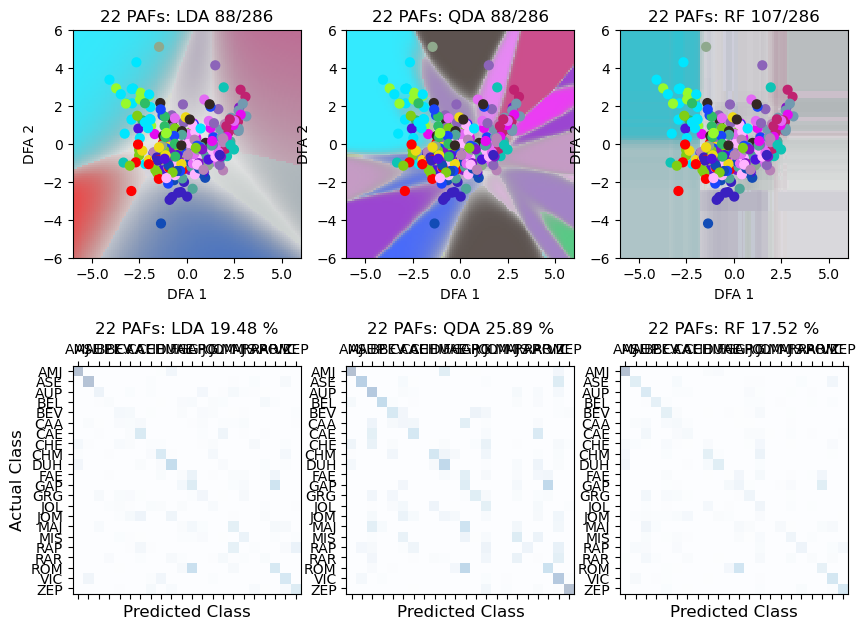

In [7]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('fund', 'cvfund', 'maxfund', 'minfund',
       'F1', 'F2', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS',
       'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT',
       'entT' ))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# 22 PAFs
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = '22 PAFs',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Mixed']),
     'Features': np.array(['PAFs']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

## Repeat by training on bath

Variance explained is 99.08%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

DFA calculated with 184 points
LDA Weights:
DFA 0: q2 0.002; maxfund -0.001; stdS -0.001; q3 0.001; F1 -0.000; 
DFA 1: stdS -0.003; maxfund 0.003; F2 0.002; meanS -0.002; q2 0.001; 
DFA 2: q1 0.002; F2 -0.002; q2 -0.002; maxfund -0.001; stdS -0.001; 
Number of classes 18. Chance level 5.56 %
Bath: 22 PAFs LDA: 45.11 % (83/184 p=0.0000)
Bath: 22 PAFs QDA: 36.41 % (67/184 p=0.0000)
Bath: 22 PAFs RF: 46.20 % (85/184 p=0.0000)


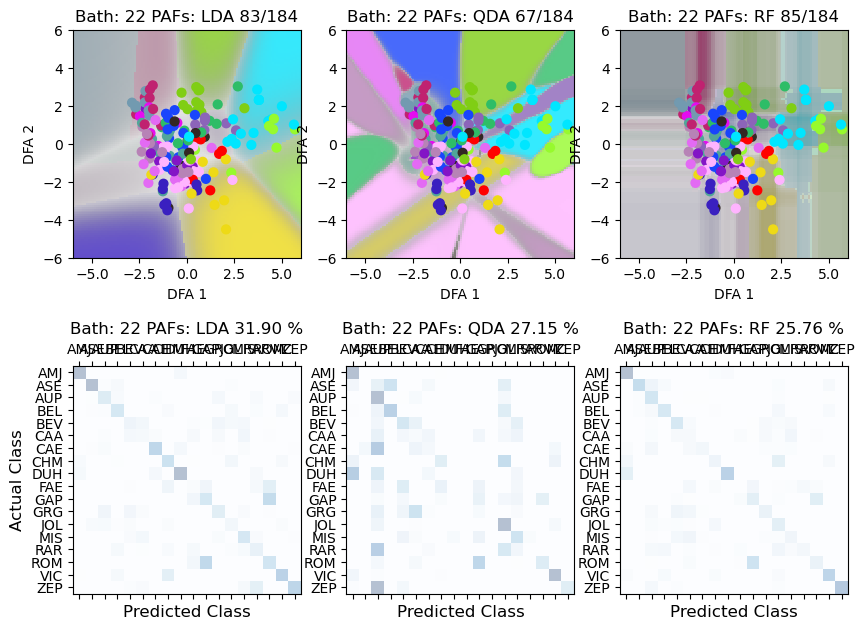

In [8]:
bathInd = np.argwhere(np.array(vocSelTable['Condition']) == 'B').flatten()

XBath = X[bathInd,:]

y = np.array(vocSelTable['Baby'])
yBath = y[bathInd]
cValBabyBath = cValBabyAll[bathInd]

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(XBath), axis = 1) == 0)

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XBath[nonanInd], yBath[nonanInd], 
                                                                                            cValBabyBath[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Bath: 22 PAFs',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Bath']),
     'Features': np.array(['PAFs']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

Variance explained is 99.79%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are colline

DFA calculated with 184 points
LDA Weights:
DFA 0: maxfund -0.002; q2 0.001; F1 0.001; F2 -0.001; q3 0.000; 
DFA 1: F1 0.008; F2 -0.002; q2 -0.001; fund 0.001; maxfund -0.001; 
DFA 2: maxfund -0.004; F2 -0.002; F1 -0.002; q1 0.001; q2 -0.001; 


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 18. Chance level 5.56 %
Bath: 10 Spectral LDA: 40.22 % (74/184 p=0.0000)
Bath: 10 Spectral QDA: 32.61 % (60/184 p=0.0000)
Bath: 10 Spectral RF: 45.65 % (84/184 p=0.0000)


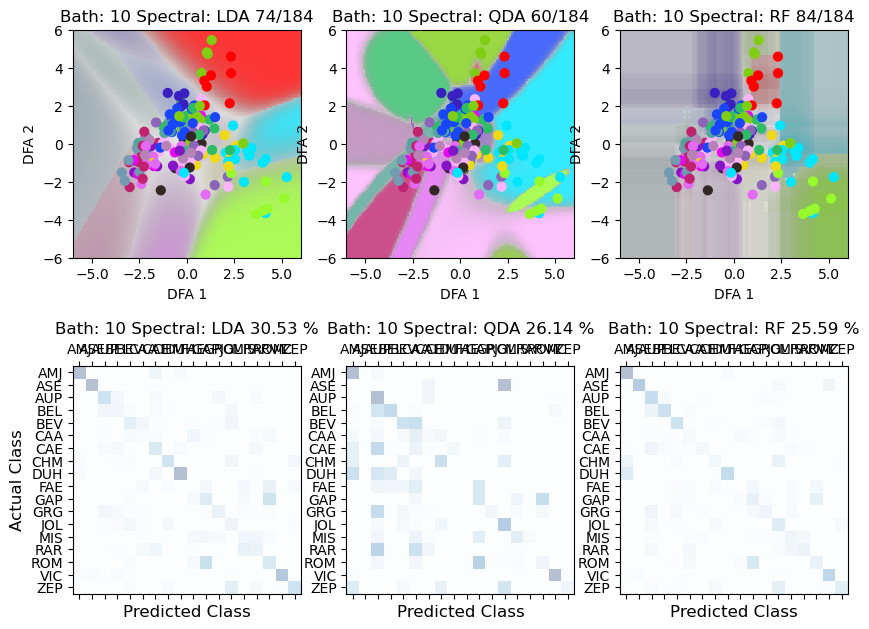

In [9]:
bathInd = np.argwhere(np.array(vocSelTable['Condition']) == 'B').flatten()

XFeatureNames = np.hstack(('F1','F2','sal', 'fund','cvfund', 'maxfund', 'minfund', 'q1', 'q2', 'q3'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)
y = np.array(vocSelTable['Baby'])

XBath = X[bathInd,:]
yBath = y[bathInd]
cValBabyBath = cValBabyAll[bathInd]

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(XBath), axis = 1) == 0)

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XBath[nonanInd], yBath[nonanInd], 
                                                                                            cValBabyBath[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Bath: 10 Spectral',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Bath']),
     'Features': np.array(['10 Spectral']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

['fund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms' 'maxAmp'
 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT' 'stdT'
 'skewT' 'kurtT' 'entT']
[]
[]
Variance explained is 99.71%
DFA calculated with 256 points
LDA Weights:
DFA 0: F1 -0.003; maxfund 0.001; meanS -0.001; stdS 0.000; fund -0.000; 
DFA 1: F1 -0.004; F2 0.002; stdS -0.002; meanS -0.002; q2 0.001; 
DFA 2: F1 0.004; maxfund 0.002; stdS -0.002; fund 0.001; q2 -0.001; 
Number of classes 18. Chance level 5.56 %
Mixed BathSet 22 PAFs LDA: 37.11 % (95/256 p=0.0000)
Mixed BathSet 22 PAFs QDA: 33.98 % (87/256 p=0.0000)
Mixed BathSet 22 PAFs RF: 41.02 % (105/256 p=0.0000)


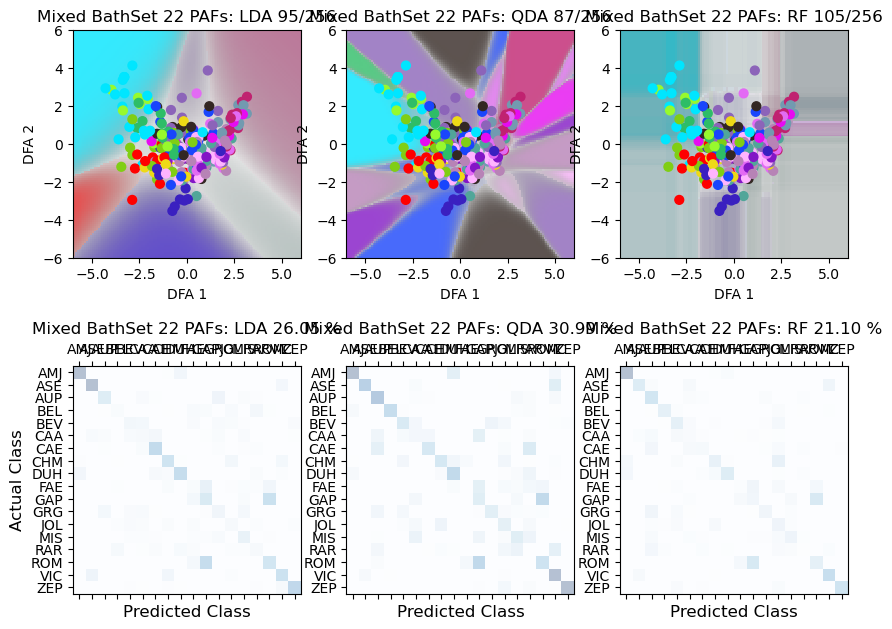

In [10]:
# Compare discrimination for the same babies with mixed
XFeatureNames = np.hstack(('fund', 'cvfund', 'maxfund', 'minfund',
       'F1', 'F2', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS',
       'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT',
       'entT' ))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)
y = np.array(vocSelTable['Baby'])

babyInd = np.array([i for i, baby in enumerate(y) if baby in classes])
XBaby = X[babyInd]
yBaby = y[babyInd]
cValBaby = cValBabyAll[babyInd]

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(XBaby), axis = 1) == 0)
nanInd = (np.sum(np.isnan(XBaby), axis = 1) != 0)

print(XFeatureNames)
print(yBaby[nanInd])
print(XBaby[nanInd])


# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XBaby[nonanInd], yBaby[nonanInd], 
                                                                                            cValBaby[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Mixed BathSet 22 PAFs',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Mixed BathSet']),
     'Features': np.array(['PAFs']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }


tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

### Repeat the analysis with cross-validation

Variance explained is 100.00%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DFA calculated with 189 points
LDA Weights:
DFA 0: cvfund 3.638; sal -1.780; minfund 0.007; F1 -0.005; fund 0.005; 
DFA 1: cvfund -2.078; sal 1.017; fund 0.019; minfund 0.002; F1 0.002; 
DFA 2: cvfund -12.482; sal 6.108; minfund -0.015; fund 0.008; maxfund 0.002; 


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 19. Chance level 5.26 %
Cross Fund + Formants LDA: 22.37 % (17/76 p=0.0000)
Cross Fund + Formants QDA: 17.11 % (13/76 p=0.0002)
Cross Fund + Formants RF: 27.63 % (21/76 p=0.0000)


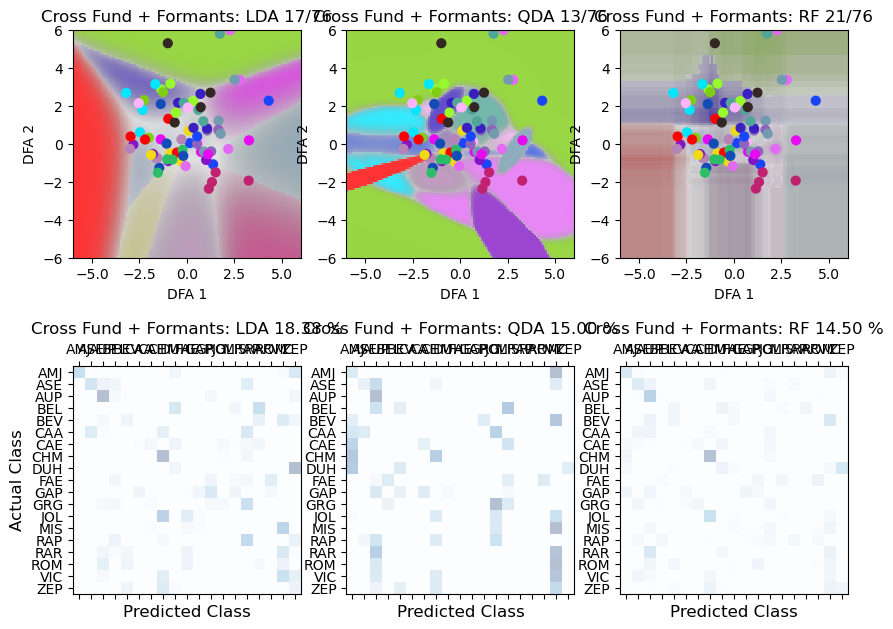

In [11]:
# Can we classify baby id using the average formants, pitch saliency, fundamental and the cv fund ?

# X is the data array of features.
# y is the variable name for the grouping variable 
XFeatureNames = np.hstack(('F1','F2','sal', 'fund','cvfund', 'maxfund', 'minfund'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)
cond = np.array(vocSelTable['Condition'])

y = np.array(vocSelTable[responseVar])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Test Indeces
# These are the rows for the data in the 'D' (Douleur == Pain from vaccination) condition
testInd = np.argwhere(cond[nonanInd] == 'D').flatten()

# Formants + Saliency + Fund Model 
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd], 
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Cross Fund + Formants',
                                                                                            figdir = figdir,
                                                                                            plotFig = True,
                                                                                             testInd = testInd)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Cross']),
     'Features': np.array(['Fund + Formants']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

     
tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

Variance explained is 100.00%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DFA calculated with 189 points
LDA Weights:
DFA 0: sal 0.340; cvfund -0.243; fund 0.020; minfund 0.005; maxfund 0.001; 
DFA 1: cvfund -16.464; sal -3.703; minfund -0.010; fund 0.006; maxfund 0.001; 
DFA 2: sal -17.861; cvfund -1.778; minfund 0.008; fund -0.006; maxfund -0.003; 


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 19. Chance level 5.26 %
Cross Fund LDA: 9.21 % (7/76 p=0.1050)
Cross Fund QDA: 10.53 % (8/76 p=0.0463)
Cross Fund RF: 15.79 % (12/76 p=0.0006)


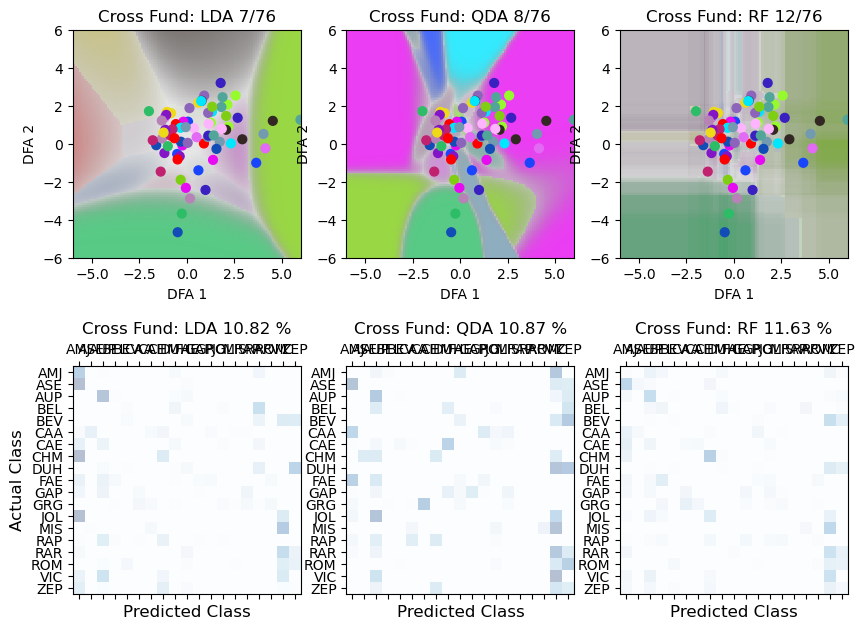

In [12]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('sal', 'fund',  'cvfund', 'minfund', 'maxfund'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Test Indices
testInd = np.argwhere(cond[nonanInd] == 'D').flatten()

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Cross Fund',
                                                                                            figdir = figdir,
                                                                                            plotFig = True,
                                                                                            testInd = testInd)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Cross']),
     'Features': np.array(['Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }


tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

Variance explained is 100.00%
DFA calculated with 189 points
LDA Weights:
DFA 0: sal -4.247; F1 -0.006; F2 0.002; 
DFA 1: sal -15.180; F1 -0.001; F2 -0.000; 
DFA 2: sal -2.701; F2 -0.005; F1 0.001; 
Number of classes 19. Chance level 5.26 %
Cross Formants LDA: 17.11 % (13/76 p=0.0002)
Cross Formants QDA: 7.89 % (6/76 p=0.2105)
Cross Formants RF: 5.26 % (4/76 p=0.5718)


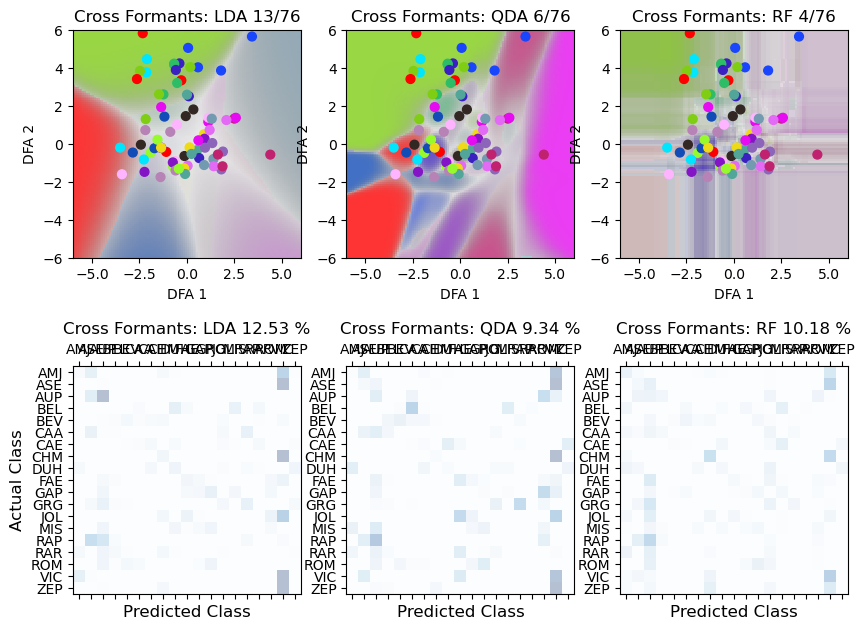

In [13]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('F1', 'F2', 'sal'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

testInd = np.argwhere(cond[nonanInd] == 'D').flatten()

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Cross Formants',
                                                                                            figdir = figdir,
                                                                                            plotFig = True,
                                                                                            testInd = testInd)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Cross']),
     'Features': np.array(['Formants']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

Variance explained is 99.07%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DFA calculated with 189 points
LDA Weights:
DFA 0: q2 -0.002; stdS 0.001; maxfund 0.001; q3 -0.001; F1 0.000; 
DFA 1: stdS -0.003; maxfund 0.002; F2 0.002; meanS -0.002; q1 -0.001; 
DFA 2: q1 0.002; F2 -0.002; q2 -0.001; stdS -0.001; F1 0.001; 


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 19. Chance level 5.26 %
Cross 22 PAFs LDA: 13.16 % (10/76 p=0.0065)
Cross 22 PAFs QDA: 15.79 % (12/76 p=0.0006)
Cross 22 PAFs RF: 13.16 % (10/76 p=0.0065)


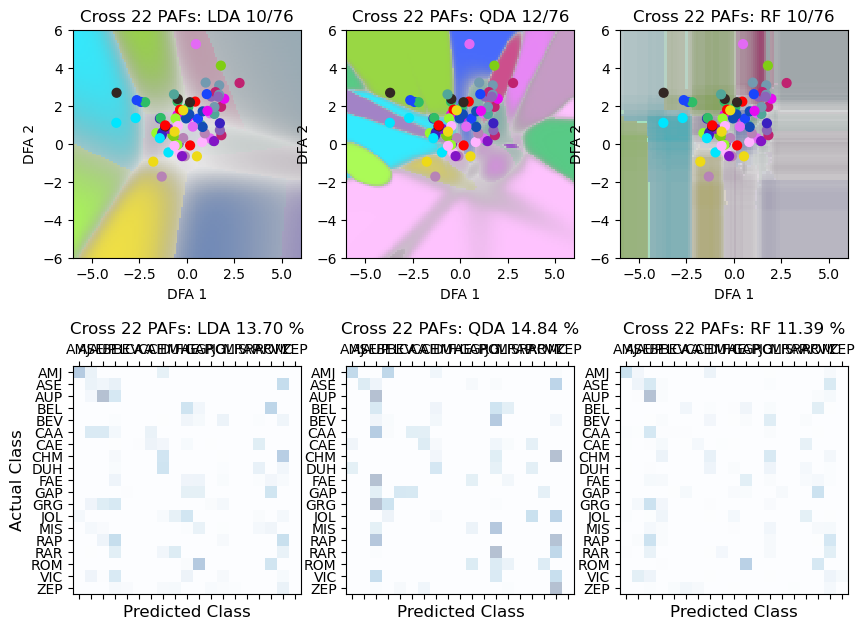

In [14]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('fund', 'cvfund', 'maxfund', 'minfund',
       'F1', 'F2', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS',
       'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT',
       'entT' ))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

testInd = np.argwhere(cond[nonanInd] == 'D').flatten()

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBabyAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Cross 22 PAFs',
                                                                                            figdir = figdir,
                                                                                            plotFig = True,
                                                                                            testInd = testInd)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Cross']),
     'Features': np.array(['PAFs']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

In [15]:
print(cvCountConf)
print(nClasses)
print(1/nClasses)

[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
19
0.05263157894736842


Variance explained is 99.08%


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DFA calculated with 184 points
LDA Weights:
DFA 0: q2 0.002; maxfund -0.001; stdS -0.001; q3 0.001; F1 -0.000; 
DFA 1: stdS -0.003; maxfund 0.003; F2 0.002; meanS -0.002; q2 0.001; 
DFA 2: q1 0.002; F2 -0.002; q2 -0.002; maxfund -0.001; stdS -0.001; 


/Users/frederictheunissen/anaconda3/envs/bioacoustics/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of classes 18. Chance level 5.56 %
Cross BathSet 22 PAFs LDA: 12.50 % (9/72 p=0.0181)
Cross BathSet 22 PAFs QDA: 16.67 % (12/72 p=0.0006)
Cross BathSet 22 PAFs RF: 13.89 % (10/72 p=0.0064)


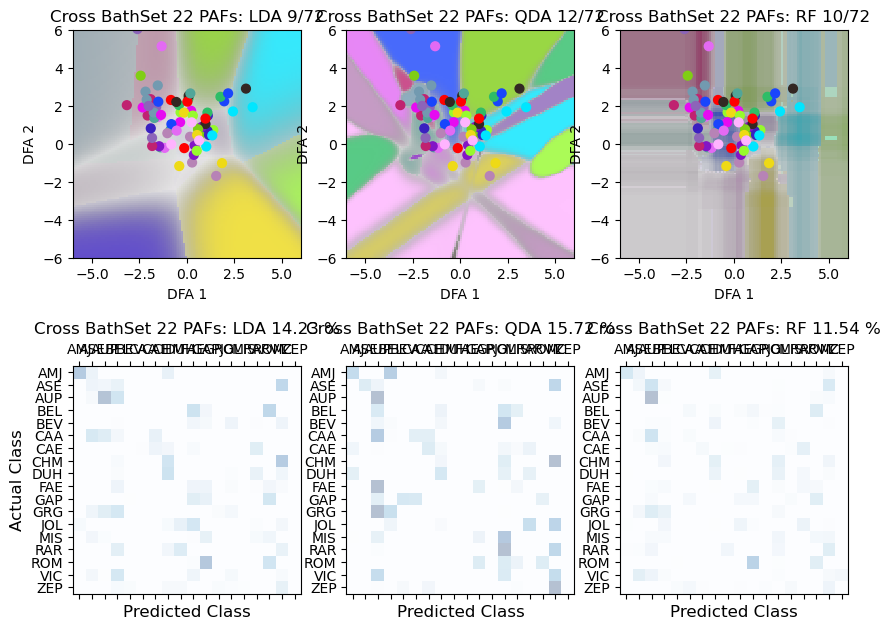

In [16]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('fund', 'cvfund', 'maxfund', 'minfund',
       'F1', 'F2', 'sal', 'rms', 'maxAmp', 'meanS', 'stdS', 'skewS',
       'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT', 'skewT', 'kurtT',
       'entT' ))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Baby'])
cond = np.array(vocSelTable['Condition'])

# 
XBaby = X[babyInd]
yBaby = y[babyInd]
cValBaby = cValBabyAll[babyInd]
condBaby = cond[babyInd]

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(XBaby), axis = 1) == 0)

testInd = np.argwhere(condBaby[nonanInd] == 'D').flatten()



# 22 PAFs
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(XBaby[nonanInd], yBaby[nonanInd], 
                                                                                            cValBaby[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Cross BathSet 22 PAFs',
                                                                                            figdir = figdir,
                                                                                            plotFig = True,
                                                                                            testInd = testInd)
#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)



d = {'Type': np.array(['Cross Bath Set']),
     'Features': np.array(['PAFs']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA %' : np.array([100.0*ldaYes/cvCount]), 
     'QDA %': np.array([100.0*qdaYes/cvCount]),
     'RF %': np.array([100.0*rfYes/cvCount]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post 2SE': np.array([200.0*post_se_lda]),
     'QDA Post 2SE': np.array([200.0*post_se_qda]),
     'RF Post 2SE': np.array([200.0*post_se_rf])
       
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf], ignore_index = True)

In [17]:
print(cvCountConf)
print(nClasses)
print(1/nClasses)

[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
18
0.05555555555555555


In [18]:
resultsDataFrame['Avg Post']=(resultsDataFrame['LDA Post']+resultsDataFrame['QDA Post']+resultsDataFrame['RF Post'])/3.0
resultsDataFrame['Avg 2SE']= 2.0* np.sqrt(((resultsDataFrame['LDA Post 2SE']/2)**2+(resultsDataFrame['QDA Post 2SE']/2)**2+(resultsDataFrame['RF Post 2SE']/2)**2)/9.0)


In [19]:
resultsDataFrame.style.format(precision = 1,
                formatter={('LDA %', 'QDA %', 'RF %'): "{:.1f}",
                           ('LDA Pval', 'QDA Pval', 'RF Pval'): "{:.4f}" }
                          )


,Type,Features,LDA Correct,QDA Correct,RF Correct,Tested,nClasses,LDA %,QDA %,RF %,LDA Pval,QDA Pval,RF Pval,LDA Post,QDA Post,RF Post,LDA Post 2SE,QDA Post 2SE,RF Post 2SE,Avg Post,Avg 2SE
0,Mixed,Formants + Fund,96,87,114,286,22,33.6,30.4,39.9,0.0,0.0,0.0,21.7,24.9,19.3,4.9,5.1,4.7,22.0,2.8
1,Mixed,Fund,54,62,71,286,22,18.9,21.7,24.8,0.0,0.0,0.0,13.0,16.9,15.2,4.0,4.4,4.2,15.0,2.4
2,Mixed,Formants,61,59,51,286,22,21.3,20.6,17.8,0.0,0.0,0.0,11.1,14.6,13.2,3.7,4.2,4.0,13.0,2.3
3,Mixed,PAFs,88,88,107,286,22,30.8,30.8,37.4,0.0,0.0,0.0,19.5,25.9,17.5,4.7,5.2,4.5,21.0,2.8
4,Bath,PAFs,83,67,85,184,18,45.1,36.4,46.2,0.0,0.0,0.0,31.9,27.1,25.8,6.9,6.6,6.4,28.3,3.8
5,Bath,10 Spectral,74,60,84,184,18,40.2,32.6,45.7,0.0,0.0,0.0,30.5,26.1,25.6,6.8,6.5,6.4,27.4,3.8
6,Mixed BathSet,PAFs,95,87,105,256,18,37.1,34.0,41.0,0.0,0.0,0.0,26.0,31.0,21.1,5.5,5.8,5.1,26.0,3.2
7,Cross,Fund + Formants,17,13,21,76,19,22.4,17.1,27.6,0.0,0.0,0.0,18.4,15.0,14.5,8.9,8.2,8.1,16.0,4.8
8,Cross,Fund,7,8,12,76,19,9.2,10.5,15.8,0.1,0.0,0.0,10.8,10.9,11.6,7.1,7.1,7.4,11.1,4.2
9,Cross,Formants,13,6,4,76,19,17.1,7.9,5.3,0.0,0.2,0.6,12.5,9.3,10.2,7.6,6.7,6.9,10.7,4.1


In [20]:
# Save pandas as excell file.
resultsDataFrame.to_excel('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/resultsPFA.xlsx')

In [22]:
# Perform the binomial and the Fisher Exact Tests

# Bath vs Mixed.
a = resultsDataFrame[(resultsDataFrame['Type'] == 'Bath') & (resultsDataFrame['Features'] == 'PAFs')]['LDA Correct'].iloc[0]
b = resultsDataFrame[(resultsDataFrame['Type'] == 'Bath') & (resultsDataFrame['Features'] == 'PAFs')]['Tested'].iloc[0] - a
c = resultsDataFrame[(resultsDataFrame['Type'] == 'Mixed BathSet')& (resultsDataFrame['Features'] == 'PAFs')]['LDA Correct'].iloc[0]
d = resultsDataFrame[(resultsDataFrame['Type'] == 'Mixed BathSet')& (resultsDataFrame['Features'] == 'PAFs')]['Tested'].iloc[0] - c
print('Comparing Bath to Mixed:', fisher_exact(np.array([[a, b], [c, d]])))

chanceP = 1.0/resultsDataFrame[(resultsDataFrame['Type'] == 'Bath') & (resultsDataFrame['Features'] == 'PAFs') ]['nClasses'].iloc[0]
print('Comparing Bath to chance:', binom_test(a, a+b, prop=chanceP, alternative='larger'))
chanceP = 1.0/resultsDataFrame[(resultsDataFrame['Type'] == 'Mixed BathSet') & (resultsDataFrame['Features'] == 'PAFs')]['nClasses'].iloc[0]
print('Comparing Mixed to chance:', binom_test(c, c+d, prop=chanceP, alternative='larger'))

# Bath vs Crossed.
a = resultsDataFrame[(resultsDataFrame['Type'] == 'Bath') & (resultsDataFrame['Features'] == 'PAFs')]['LDA Correct'].iloc[0]
b = resultsDataFrame[(resultsDataFrame['Type'] == 'Bath') & (resultsDataFrame['Features'] == 'PAFs')]['Tested'].iloc[0] - a
c = resultsDataFrame[(resultsDataFrame['Type'] == 'Cross Bath Set') & (resultsDataFrame['Features'] == 'PAFs')]['LDA Correct'].iloc[0]
d = resultsDataFrame[(resultsDataFrame['Type'] == 'Cross Bath Set') & (resultsDataFrame['Features'] == 'PAFs')]['Tested'].iloc[0] - c
print('Comparing Bath to Crossed:', fisher_exact(np.array([[a, b], [c, d]])))

chanceP = 1.0/resultsDataFrame[(resultsDataFrame['Type'] == 'Cross Bath Set') & (resultsDataFrame['Features'] == 'PAFs')]['nClasses'].iloc[0]
print('Comparing Mixed to chance:', binom_test(c, c+d, prop=chanceP, alternative='larger'))

# Mixed vs Crossed.
a = resultsDataFrame[(resultsDataFrame['Type'] == 'Mixed BathSet') & (resultsDataFrame['Features'] == 'PAFs')]['LDA Correct'].iloc[0]
b = resultsDataFrame[(resultsDataFrame['Type'] == 'Mixed BathSet') & (resultsDataFrame['Features'] == 'PAFs')]['Tested'].iloc[0] - a
c = resultsDataFrame[(resultsDataFrame['Type'] == 'Cross Bath Set') & (resultsDataFrame['Features'] == 'PAFs')]['LDA Correct'].iloc[0]
d = resultsDataFrame[(resultsDataFrame['Type'] == 'Cross Bath Set') & (resultsDataFrame['Features'] == 'PAFs')]['Tested'].iloc[0] - c
print('Comparing Mixed to Crossed:', fisher_exact(np.array([[a, b], [c, d]])))


Comparing Bath to Mixed: SignificanceResult(statistic=1.3927045336112558, pvalue=0.09523403250627079)
Comparing Bath to chance: 1.3018593356537604e-53
Comparing Mixed to chance: 6.863583837190249e-52
Comparing Bath to Crossed: SignificanceResult(statistic=5.752475247524752, pvalue=5.155169728057018e-07)
Comparing Mixed to chance: 0.018076851756165066
Comparing Mixed to Crossed: SignificanceResult(statistic=4.130434782608695, pvalue=4.691411087665107e-05)


In [23]:
predSuccess = []
predSuccessI = []

for irow, row in subjectInfo.iterrows():    
    iactual = np.argwhere(classes == row['assignedID'])[0]
    jtested = np.argwhere((classes == row['stranger1']) | (classes == row['stranger2']) 
                          | (classes == row['stranger3']) | (classes == row['stranger4']) ).flatten()
    
    # Probabilities based on assignedID
    pfound = lda_conf[iactual,iactual]
    pother = (1-pfound)/(nClasses-1)
    psum = pfound + 4*pother
    pfound /= psum
    pother /= psum
    
    # Probabilities based on assigned and stranges
    pfoundI = lda_conf[iactual,iactual]
    if len(jtested) == 0 :
        potherI = (1-pfound)/(nClasses-1)
    else:
        potherI = np.mean(lda_conf[iactual, jtested])
        
    psum = pfoundI + 4*potherI
    pfoundI /= psum
    potherI /= psum
    
    # Stuff the data on the same data frame
    predSuccess.append(pfound[0])
    predSuccessI.append(pfoundI[0])
    
subjectInfo['predSuccess'] = predSuccess
subjectInfo['predSuccessI'] = predSuccessI


[Text(0.5, 1.0, 'R2 -0.01 p 0.9645 AvgS 52.1% AvgLDA 31.0%')]

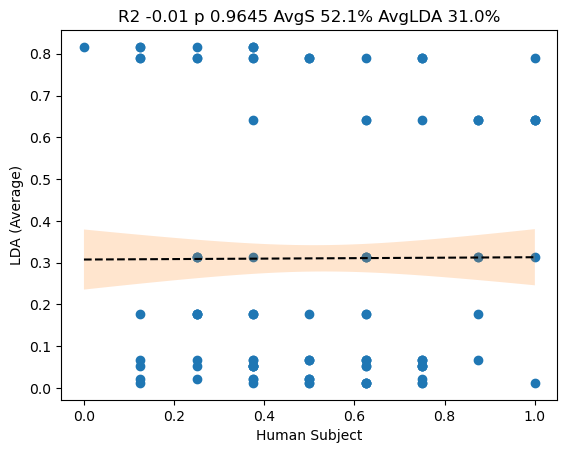

In [24]:
fig, ax = plt.subplots()
x = subjectInfo['success']
y = subjectInfo['predSuccess']

ax.scatter(x,y)

    
plt.xlabel('Human Subject')
plt.ylabel('LDA (Average)')

# fit a linear curve an estimate its y-values and their error.


n = len(x)
a, b = np.polyfit(x, y, deg=1)
    
sse = np.sum((y-(a*x+b))**2)
xmean = np.mean(x)
ssx = np.sum((x - xmean)**2)
sst = np.sum((y-np.mean(y))**2)
syx = np.sqrt(sse/(n-2))
sy  = np.sqrt(sst/(n-1))
r2adj = 1. - syx**2/sy**2
fval = (sst-sse)/syx**2
pval = 1. - f.cdf(fval, dfn=1, dfd=n-2)

# Plot the line 
xsel = np.linspace(x.min(), x.max(), num=100)
    
y_est = a * xsel + b
y_err = syx * np.sqrt(1/n + (xsel - xmean)**2 / np.sum((x - xmean)**2))


ax.plot(xsel, y_est, '--', color = 'k')
ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax.set(title='R2 %.2f p %.4f AvgS %.1f%% AvgLDA %.1f%%' % ( r2adj, pval, 100*subjectInfo['success'].mean(), 100*subjectInfo['predSuccess'].mean()  ) )

[Text(0.5, 1.0, 'R2 -0.01 p 0.6488 AvgS 52.1% AvgLDA 41.8%')]

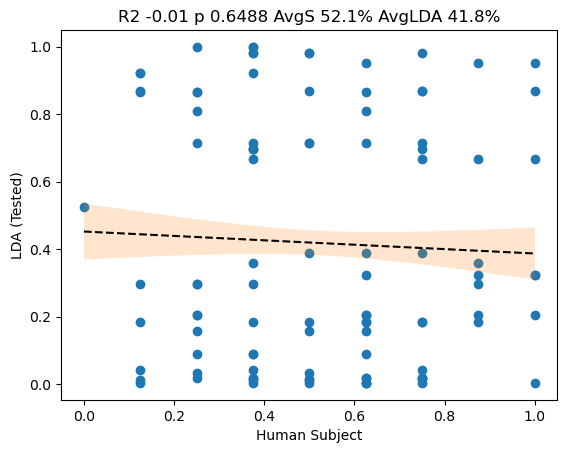

In [25]:
fig, ax = plt.subplots()
x = subjectInfo['success']
y = subjectInfo['predSuccessI']

ax.scatter(x,y)

    
plt.xlabel('Human Subject')
plt.ylabel('LDA (Tested)')

# fit a linear curve an estimate its y-values and their error.


n = len(x)
a, b = np.polyfit(x, y, deg=1)
    
sse = np.sum((y-(a*x+b))**2)
xmean = np.mean(x)
ssx = np.sum((x - xmean)**2)
sst = np.sum((y-np.mean(y))**2)
syx = np.sqrt(sse/(n-2))
sy  = np.sqrt(sst/(n-1))
r2adj = 1. - syx**2/sy**2
fval = (sst-sse)/syx**2
pval = 1. - f.cdf(fval, dfn=1, dfd=n-2)

# Plot the line 
xsel = np.linspace(x.min(), x.max(), num=100)
    
y_est = a * xsel + b
y_err = syx * np.sqrt(1/n + (xsel - xmean)**2 / np.sum((x - xmean)**2))


ax.plot(xsel, y_est, '--', color = 'k')
ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax.set(title='R2 %.2f p %.4f' % ( r2adj, pval) )
ax.set(title='R2 %.2f p %.4f AvgS %.1f%% AvgLDA %.1f%%' % ( r2adj, pval, 100*subjectInfo['success'].mean(), 100*subjectInfo['predSuccessI'].mean()  ) )